# Customer Segmentation and Analysis
Steps to solve the problem :
* Importing Libraries.
* Exploration of data.
* Data Visualization.
* Clustering using K-Means and other Clustering Algorithms.
* Selection of Clusters.
* Ploting the Cluster Boundry and Clusters.
* 3D Plot of Clusters.

In [1]:
import os
import random
import itertools
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import (
    DBSCAN,
    AffinityPropagation,
    MeanShift,
    MiniBatchKMeans,
    KMeans,
    AgglomerativeClustering,
    estimate_bandwidth,
)
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)


# Data

In [2]:
df = pd.read_csv('dataset/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [4]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
df.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [7]:
df['Gender2'] = df['Gender'].map({'Female' : 0 , 'Male' : 1})

In [8]:
df2 = df.drop(['CustomerID' , 'Gender'] , axis = 1)

# Data Visualization

In [9]:
plt.style.use('fivethirtyeight')

## Histogram

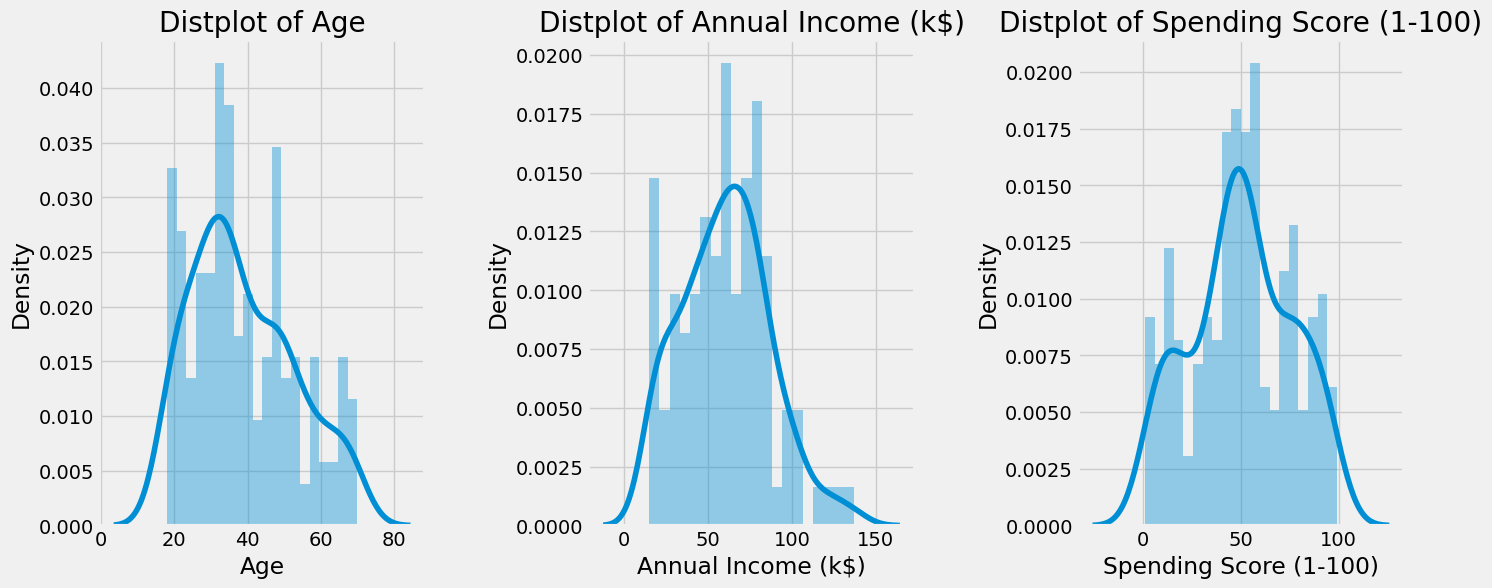

In [10]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title(f'Distplot of {x}')
plt.show()

## Count Plot of Gender

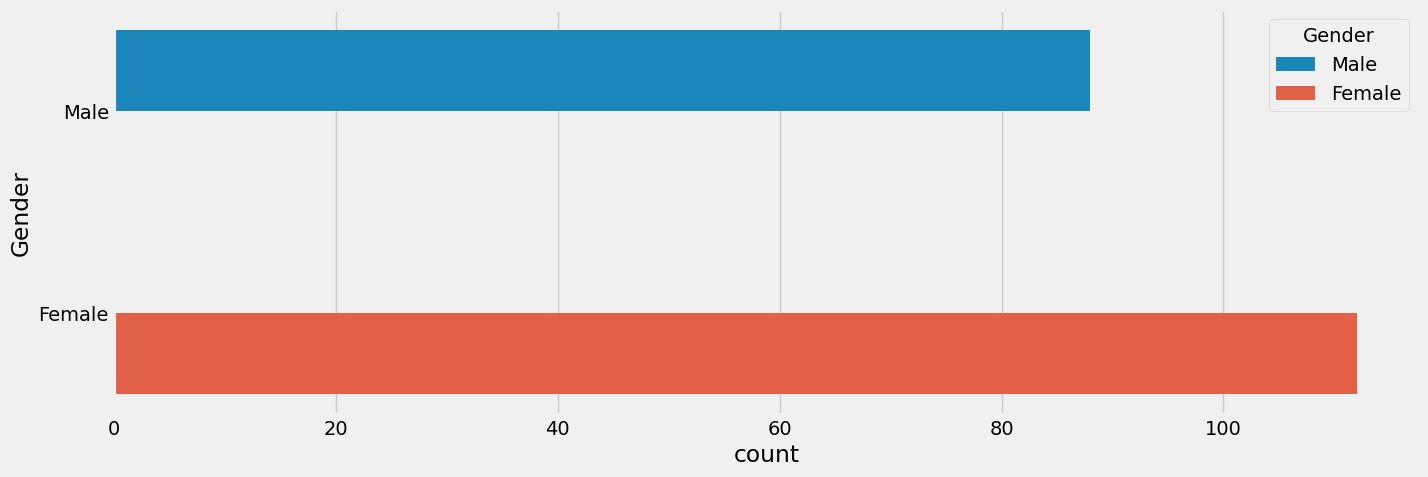

In [11]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender' , data = df, hue='Gender')
plt.show()

Ploting the Relation between Age , Annual Income and Spending Score

In [12]:
# hello 

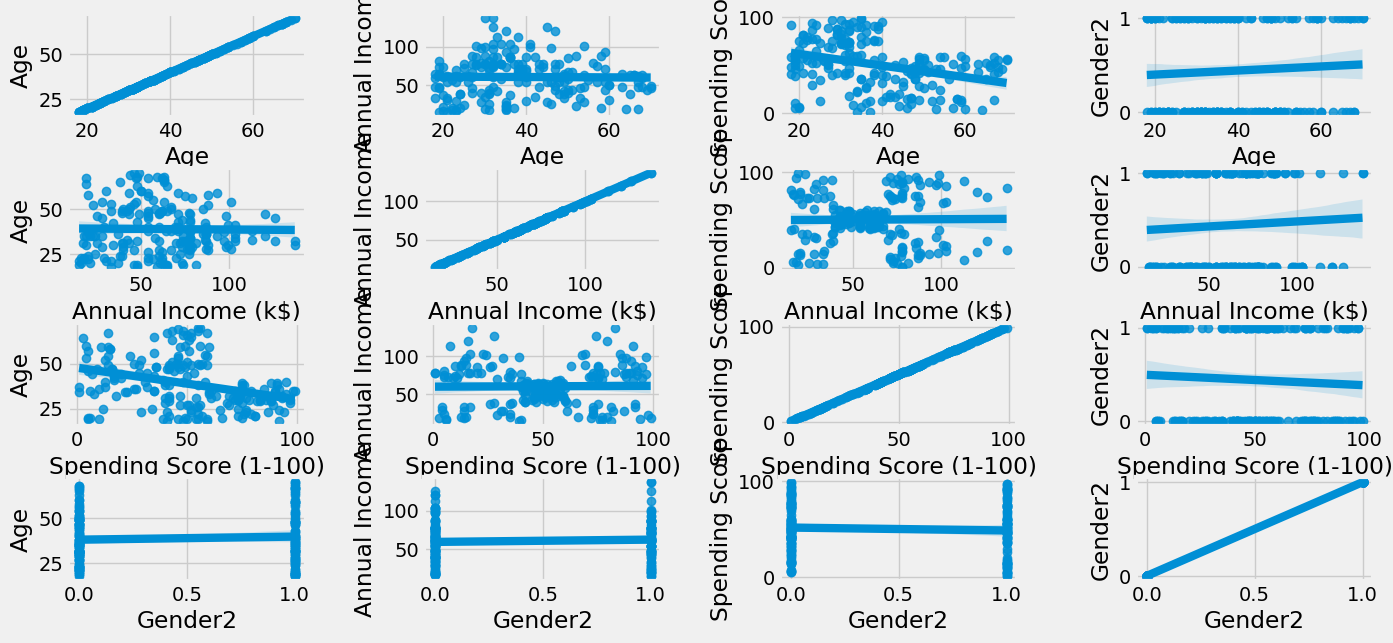

In [13]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for x in df2.columns:
    for y in df2.columns:
        n += 1
        plt.subplot(len(df2.columns) , len(df2.columns) , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

In [14]:
df2.corr()

,Age,Annual Income (k$),Spending Score (1-100),Gender2
Age,1.000000,-0.012398,-0.327227,0.060867
Annual Income (k$),-0.012398,1.000000,0.009903,0.056410
Spending Score (1-100),-0.327227,0.009903,1.000000,-0.058109
Gender2,0.060867,0.056410,-0.058109,1.000000


<Axes: >

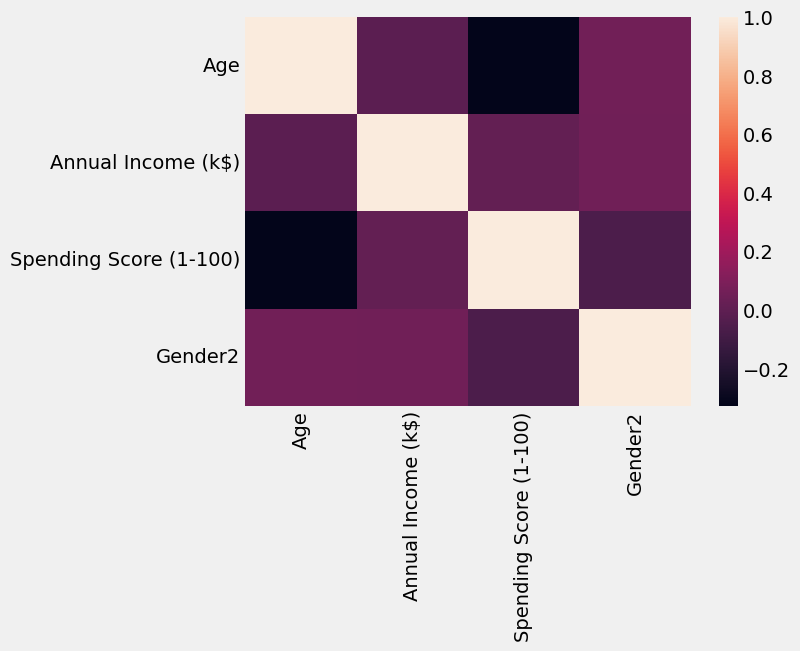

In [15]:
sns.heatmap(df2.corr())

I must say it makes good sense to see negative correlation between Age and Spending Score, People with greater age spend less (wisdom speaks)

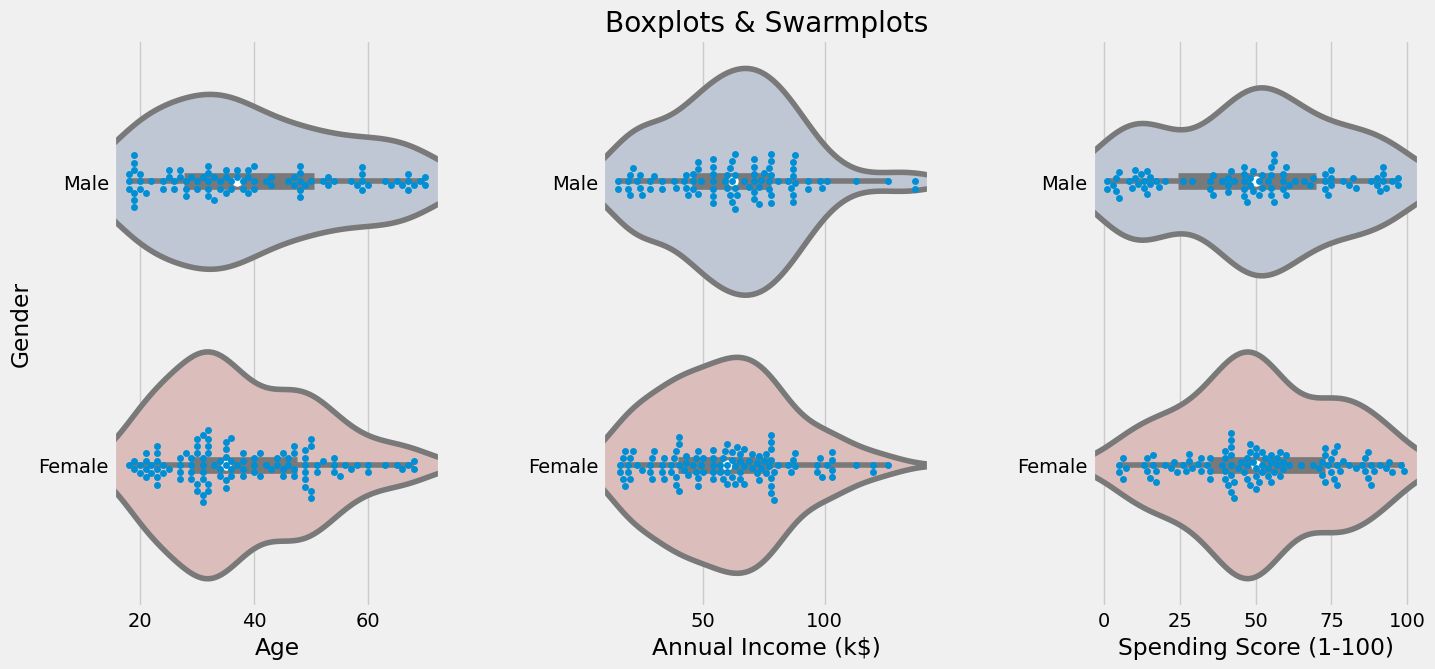

In [16]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for cols in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1 
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.violinplot(x = cols , y = 'Gender' , data = df , palette = 'vlag')
    sns.swarmplot(x = cols , y = 'Gender' , data = df)
    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Boxplots & Swarmplots' if n == 2 else '')
plt.show()

# Model Building

try it all

## Functions

In [17]:
def plot_silhouette(name, cluster_labels, x, ax=None, **kwargs):

    if ax is None:
        fig, ax = plt.subplots()

    # Compute silhouette score
    silhouette_avg = silhouette_score(x, cluster_labels)
    ax.set_title(f"{name} - Silhouette Score: {silhouette_avg:.2f}")

    # Compute silhouette values for each data point
    sample_silhouette_values = silhouette_samples(x, cluster_labels)

    y_lower = 10
    for i in range(cluster_labels.max() + 1):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.Spectral(float(i) / cluster_labels.max())
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7, **kwargs)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster label")
    ax.set_title(f"{name}: Clusters({cluster_labels.max() + 1}) Silhouette Score({silhouette_avg:.2f})")
    # The vertical line for the average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_xlim(-0.2, 1)

    return ax



In [18]:
def get_random_params(params):
    return {k: random.choice(v) for k, v in params.items()}

In [19]:
def scorer(algorithm, X, y=None, *args, **kwargs):    
    algorithm.fit(X)
    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)
    silhouette_avg = silhouette_score(X, y_pred)
    return -silhouette_avg

In [20]:

def random_search(model, params, x, n_iter=10, scorer=None, cv=None, random_state=42):
    # Create a GridSearchCV object with the specified parameter grid and evaluation metric
    grid_search = RandomizedSearchCV(model, params, n_iter = n_iter, scoring=scorer, cv=cv, random_state=random_state, n_jobs=-1)

    # Fit the grid search to your data
    grid_search.fit(x)

    # Get the best hyperparameters and the best silhouette score
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_

    print("Best Hyperparameters:", best_params)
    print("Best Silhouette Score:", best_score)
    return grid_search

In [21]:

def get_cluster_centers(X, cluster_labels, n_clusters):
    centers = np.zeros((n_clusters, X.shape[1]))
    for i in range(n_clusters):
        centers[i] = np.mean(X[cluster_labels == i], axis=0)
    return centers

In [22]:
def plot_scatter_2d(x, cluster_labels, n_clusters=None, ax=None, random_state=42, **kwargs):

    if n_clusters is None:
        n_clusters = len(np.unique(cluster_labels))
        
    if x.shape[-1] < 2:
        x = PolynomialFeatures(2).fit_transform(x)

    if x.shape[-1] != 2:
        x = TSNE(n_components=2, random_state=random_state).fit_transform(x)
        
    if ax is None:
        fig, ax = plt.subplots()
        
    if 'c' not in kwargs:
        kwargs['c'] = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    ax.scatter(x[:, 0], x[:, 1], **kwargs)
    
    centers = get_cluster_centers(x, cluster_labels, n_clusters)
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers,1):
        ax.scatter(c[0], c[1], marker="$%d$" % i)

    return ax

In [23]:

def plot_scatter_3d(x, cluster_labels, n_clusters=None, ax=None, random_state=42,**kwargs):
    
    
    if n_clusters is None:
        n_clusters = len(np.unique(cluster_labels))

    if x.shape[-1] < 3:
        x = PolynomialFeatures(2).fit_transform(x)
        
    if x.shape[-1] != 3:
        x = TSNE(n_components=3, random_state=random_state).fit_transform(x)
        
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
    if 'c' not in kwargs:
        kwargs['c'] = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)


    ax.scatter(X[:, 0], X[:, 1], X[:, 2], **kwargs)

    centers = get_cluster_centers(X, cluster_labels, n_clusters)
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        centers[:, 2],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers, 1):
        ax.scatter(c[0], c[1], c[2], marker="$%d$" % i)

    return ax

In [24]:
def plot_datapoints(x, y, n_components=2, title=None):
    
    if n_components not in [2, 3]:
        raise ValueError("n_components must be in [2, 3]")
        
    if x.shape[-1] != n_components:
        x = TSNE(n_components=n_components, random_state=42).fit_transform(x)
    
    x = pd.DataFrame(x, columns=["x", "y", "z"] if n_components == 3 else ["x", "y"])
    x['cluster']=y
    x['cluster'] = x['cluster'].astype('category')
    if n_components == 2:
        fig=px.scatter(data_frame=x, x='x', y='y', color='cluster', symbol='cluster', title=title)
    else:
        fig=px.scatter_3d(data_frame=x, x='x', y='y', z='z', color='cluster', symbol='cluster', title=title)
    
    fig.show()


In [25]:
class ClusterAnalyzer:
    def __init__(self, X, range_n_clusters):
        self.X = X
        self.range_n_clusters = range_n_clusters
    
        self.default_silhouette_kwargs = {
        }
        
        self.default_scatter_kwargs = {
                "marker": ".",
                "s": 200,
                "lw": 0,
                "alpha": 0.6,
                "edgecolor": "k"
            }
   
        
    def analyze_clusters(self, cluster_model, name, projection='2d', silhouette_kwargs=None, scatter_kwargs=None):
        if projection not in ['2d','3d']:
            raise ValueError('Should be 2d or 3d')
            
        for n_clusters in self.range_n_clusters:
            # Create a subplot with 1 row and 2 columns
            fig = plt.figure(figsize=(8,3))
            # fig.suptitle('A tale of 2 subplots')
            
            # First subplot
            ax1 = fig.add_subplot(1, 2, 1)
            # Second subplot
            if projection=='3d':
                ax2 = fig.add_subplot(1, 2, 2, projection='3d')
            else:
                ax2 = fig.add_subplot(1, 2, 2)
                

            # The 1st subplot is the silhouette plot
            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(self.X) + (n_clusters + 1) * 10])

            # get clusters
            cluster_labels = cluster_model(self.X, n_clusters) 

            # Silhouette plot
            silhouette_kwargs = silhouette_kwargs or self.default_silhouette_kwargs
            plot_silhouette(name, cluster_labels, self.X, ax1, **silhouette_kwargs)  

            # Scatter plot
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            self.default_scatter_kwargs["c"] = colors
            scatter_kwargs = scatter_kwargs or self.default_scatter_kwargs
            if projection=='2d':
                plot_scatter_2d(self.X, cluster_labels, n_clusters, ax2, **scatter_kwargs)
            else:
                plot_scatter_3d(self.X, cluster_labels, n_clusters, ax=ax2, **scatter_kwargs)
            plt.suptitle(
                f"Silhouette analysis for clustering with {n_clusters} clusters",
                # fontsize=14,
                fontweight="bold",
            )

            plt.show()
            

    def get_cluster_centers(self, cluster_labels, n_clusters):
        centers = []
        for i in range(n_clusters):
            cluster_points = self.X[cluster_labels == i]
            cluster_center = np.mean(cluster_points, axis=0)
            centers.append(cluster_center)
        return np.array(centers)


def kmeans_cluster(X, n_clusters):
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    return clusterer.fit_predict(X)

def dbscan_cluster(X, eps):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    return dbscan.fit_predict(X)

def mini_batch_kmeans_cluster(X, n_clusters):
    dbscan = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, batch_size=1024, verbose=0, compute_labels=True, tol=0.0, max_no_improvement=10, n_init='warn', reassignment_ratio=0.01)
    return dbscan.fit_predict(X)


In [26]:
x = df2.values

# Standardize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [27]:
def give_a_predictor(model, params:dict)->callable:
    model = model.set_params(**params)
    def model_cluster(x, n_clusters:int)->np.ndarray:
        model.set_params(n_clusters=n_clusters)
        return model.fit_predict(x)
    return model_cluster

In [28]:
kk = give_a_predictor(KMeans(), {'n_clusters':4})

In [29]:
a = kk(x_scaled,3)
a

array([0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0,
       2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0, 2, 2, 1, 0,
       2, 2, 0, 2, 1, 2, 2, 2, 1, 0, 2, 1, 0, 2, 1, 1, 1, 2, 0, 1, 2, 0,
       0, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 0, 0, 2, 1, 0, 1, 0, 2, 1, 1, 1,
       1, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 1, 0, 1, 0, 1, 0,
       2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0,
       2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0,
       1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0,
       1, 0], dtype=int32)

In [30]:
a

array([0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0,
       2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0, 2, 2, 1, 0,
       2, 2, 0, 2, 1, 2, 2, 2, 1, 0, 2, 1, 0, 2, 1, 1, 1, 2, 0, 1, 2, 0,
       0, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 0, 0, 2, 1, 0, 1, 0, 2, 1, 1, 1,
       1, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 1, 0, 1, 0, 1, 0,
       2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0,
       2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0,
       1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0,
       1, 0], dtype=int32)

In [31]:
# analyzer = ClusterAnalyzer(x_scaled, range_n_clusters)
# analyzer.analyze_clusters(kmeans_cluster, "KMeans", projection='2d')


In [32]:
bandwidth = [estimate_bandwidth(x_scaled, quantile=quantile, n_samples=10) for quantile in np.linspace(0.35, 1.0, 10)]

In [33]:
bandwidth

[1.6327490378927465,
 2.066380931911182,
 2.066380931911182,
 2.15674589503544,
 2.426318086244577,
 2.7087152452708496,
 2.7087152452708496,
 2.925433593915991,
 3.4040782290687703,
 4.085696524791209]

In [34]:
params = {
    'ap': {
        'damping': [0.5       , 0.55444444, 0.60888889, 0.66333333, 0.71777778,
       0.77222222, 0.82666667, 0.88111111, 0.93555556, 0.99      ] ,
        'convergence_iter': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ,
    },
    'kmeans': {
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
        'init':['k-means++', 'random'], 
        'n_init': ['auto'],
        'tol':[0.001, 0.01, 0.1],
    },

    'meanshift':{
        'bandwidth':bandwidth,
    },
    'dbscan':{
        'eps':[0.51, 0.6, 0.7, 0.8, 0.9, 0.99],
    },
    'spectral':{
#         'eigen_solver':['arpack', 'lobpcg', 'amg'],
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
        'n_init':[ 5,  7,  9, 11, 13, 15, 17, 19],
        'gamma':[0.5       , 0.66555556, 0.83111111, 0.99666667, 1.16222222,
       1.32777778, 1.49333333, 1.65888889, 1.82444444, 1.99      ],
#         'affinity':['rbf', 'nearest_neighbors', 'precomputed_nearest_neighbors'],
        'n_neighbors': [ 5,  7,  9, 11, 13, 15, 17, 19],
    },
    'agg':{
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
#         'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
        'linkage': ['ward', 'complete', 'average', 'single'],
        'compute_distances': [True, False]
    },
    'hdbscan':{
        'min_cluster_size': [10, 15, 20], 
        'min_samples': [None, 5, 10, 15],
        'metric': ['euclidean', 'manhattan'], #, 'cosine'], 'precomputed'], 
        'alpha': [1.0, 0.5, 1.5],
        'algorithm': ['auto', 'brute', 'kdtree', 'balltree'],
        'cluster_selection_method': ['eom', 'leaf'],
    },
    'birch':{
        'threshold': [0.1, 0.3, 0.5, 0.7],
        'branching_factor': [10, 30, 50, 70],
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
    },
    'optics':{
#         'max_eps': np.linspace(0.1, 0.99, 10),
        'metric': ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan'],
        'p': [1, 2, 3],
        'cluster_method': ['xi', 'dbscan'],
#         'eps': [None, 0.1, 0.5, 1.0, 2.0],
        'xi': [0.01, 0.05, 0.1, 0.2],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 30, 50, 100]
    },
    'gmm':{
        'n_components': [2,3,4,5,6,7,8],
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1],
        'reg_covar': [1e-7, 1e-6, 1e-5],
        'n_init': [1, 5, 10],
        'init_params': ['kmeans', 'k-means++', 'random']
    },
    'bgmm':{
        'n_components': [2,3,4,5,6,7,8],
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1],
        'reg_covar': [1e-7, 1e-6, 1e-5],
        'n_init': [1, 5, 10],
        'init_params': ['kmeans', 'k-means++', 'random']
    },
    'bkmeans':{
        'n_clusters': [2,3,4,5,6,7,8],
        'init': ['k-means++','random'],
        'n_init': [1, 5, 10],
        'tol': [1e-4, 1e-3, 1e-2],
        'algorithm': [ 'elkan', 'lloyd'],
#         'bisecting_strategy': ['biggest_inertia', 'largest_cluster']
    }
}

In [35]:
from sklearn import cluster, mixture
import sklearn

In [36]:
models = {
    "kmeans": KMeans(n_clusters=8, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=42, algorithm='lloyd'),
    "ap": AffinityPropagation(),
    "meanshift": MeanShift(bandwidth=1.0, bin_seeding=False, n_jobs=-1),
    'dbscan': DBSCAN(eps=0.5, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, n_jobs=-1),
    'spectral':cluster.SpectralClustering(n_clusters=8, gamma=1.0, affinity='rbf', n_neighbors=10, ),
    'agg': cluster.AgglomerativeClustering(n_clusters=2),
    'birch': cluster.Birch(n_clusters=8),
    'hdbscan':cluster.HDBSCAN(),
    'optics':cluster.OPTICS(),
    'gmm':mixture.GaussianMixture(),
    'bgmm':mixture.BayesianGaussianMixture(),
    'bkmeans':cluster.BisectingKMeans(),
    
    
    
}

In [37]:
# import random
# import pandas as pd
# from sklearn import metrics
# from sklearn.metrics import silhouette_score
# from itertools import product
# from sklearn.base import BaseEstimator, ClusterMixin
# import numpy as np

# class ClusterRandomizedSearchCV(BaseEstimator, ClusterMixin):
#     def __init__(self, model, param_distributions, n_iter=10, scoring='silhouette_score', random_state=None):
#         self.model = model
#         self.param_distributions = param_distributions
#         self.n_iter = n_iter
        
#         if isinstance(scoring, str):
#             scoring = [scoring]
            
#         self.scoring = scoring
#         self.random_state = random_state
#         self.results = []

#     def fit(self, X):
#         np.random.seed(self.random_state)

#         for _ in range(self.n_iter):
#             params = self._get_random_params()
#             model = self.model.set_params(**params)
#             labels = model.fit_predict(X)
#             all_scores = {}
#             for scoring_ in self.scoring:
#                 score = self._evaluate_score(X, labels, scoring_)
#                 all_scores.update(score)
#             self.results.append({'params': params, **all_scores})

#         best_result = max(self.results, key=lambda x: x[self.scoring[0]])
#         self.best_params_ = best_result['params']
#         self.best_score_ = best_result[self.scoring[0]]
#         self.best_estimator_ = self.model.set_params(**self.best_params_)

#     def _get_random_params(self):
#         params = {}
#         for key, value in self.param_distributions.items():
#             if isinstance(value, list):
#                 params[key] = random.choice(value)
#             elif isinstance(value, tuple) and len(value) == 2 and all(isinstance(v, (int, float)) for v in value):
#                 params[key] = random.uniform(value[0], value[1])
#             else:
#                 raise ValueError(f"Invalid parameter distribution for {key}")
#         return params

#     def _evaluate_score(self, X, labels, scoring):
#         if scoring == 'silhouette_score':
#             score= silhouette_score(X, labels)
#         elif scoring == 'davies_bouldin_score':
#             score= metrics.davies_bouldin_score(X, labels)
#         elif scoring == 'calinski_harabasz_score':
#             score= metrics.calinski_harabasz_score(X, labels)
#         else:
#             raise ValueError(f"Invalid scoring metric: {scoring}")
            
#         return {scoring: score}

#     def results_(self):
#         print('Higher Calinski-Harabasz score relates to a model with better defined clusters.')
#         print('Higher Silhouette score relates to a model with better defined clusters.')
#         print('Lower Davies-Bouldin index relates to a model with better separation between the clusters..')
#         results_df = pd.DataFrame(self.results)
#         param_columns = list(self.param_distributions.keys())
#         for param_column in param_columns:
#             results_df[param_column] = results_df['params'].apply(lambda x: x[param_column])

#         return results_df


In [38]:
a = np.unique([1, 2,2,2,2,2, 3, 7, 8, 9]).size
a

6

In [80]:
def get_random_params(params):
    return {k: random.choice(v) for k, v in params.items()}

In [81]:
get_random_params(params['kmeans'])

{'n_clusters': 5, 'init': 'k-means++', 'n_init': 'auto', 'tol': 0.01}

In [228]:
import random
import pandas as pd
from sklearn import metrics
from sklearn.metrics import silhouette_score
from itertools import product
from sklearn.base import BaseEstimator, ClusterMixin
import numpy as np

class ClusterRandomizedSearch: #(BaseEstimator, ClusterMixin)
    def __init__(self, model, param_distributions, n_iter=10, scoring='silhouette_score', random_state=None):
        self.model = model
        self.param_distributions = param_distributions
        self.n_iter = n_iter

        if isinstance(scoring, str):
            scoring = [scoring]

        self.scoring = scoring
        self.random_state = random_state
        self.results = []
        self.combinations = self.get_all_combinations(self.param_distributions)
        random.shuffle(self.combinations)
        self.used_combinations = set()
        self.n_iter = min(self.n_iter, len(self.combinations))

    def fit(self, X):
        np.random.seed(self.random_state)
        for i in range(self.n_iter):
            params = self.combinations.pop()
            model = self.model.set_params(**params)
            labels = model.fit_predict(X)
            n_labels = np.unique(labels).size
            if n_labels == 1:
                continue
            
            all_scores = {}
            for scoring_ in self.scoring:
                score = self._evaluate_score(X, labels, scoring_)
                all_scores.update(score)
            self.results.append({'params': params, **all_scores})

        best_result = max(self.results,default=np.nan, key=lambda x: x[self.scoring[0]])
        self.best_params_ = best_result['params']
        self.best_score_ = best_result[self.scoring[0]]
        self.best_estimator_ = self.model.set_params(**self.best_params_)

    def _get_random_params(self):
        for param in self.combinations:
            yield {key: value for key, value in param.items()}

    def get_all_combinations(self, parameter_dict):
        parameter_names = list(parameter_dict.keys())
        parameter_values = list(parameter_dict.values())

        combinations = list(product(*parameter_values))
        return [{param_name: value for param_name, value in zip(parameter_names, combo)} for combo in combinations]

    def _evaluate_score(self, X, labels, scoring):
        if scoring == 'silhouette_score':
            score = silhouette_score(X, labels)
        elif scoring == 'davies_bouldin_score':
            score = metrics.davies_bouldin_score(X, labels)
        elif scoring == 'calinski_harabasz_score':
            score = metrics.calinski_harabasz_score(X, labels)
        else:
            raise ValueError(f"Invalid scoring metric: {scoring}")

        return {scoring: score}
    
    def results_(self):
        print('Higher Calinski-Harabasz score relates to a model with better-defined clusters.')
        print('Higher Silhouette score relates to a model with better-defined clusters.')
        print('Lower Davies-Bouldin index relates to a model with better separation between the clusters.')
        
        results_df = pd.DataFrame(self.results)
        param_columns = list(self.param_distributions.keys())
        for param_column in param_columns:
            results_df[param_column] = results_df['params'].apply(lambda x: x[param_column])

        return results_df.style.highlight_max(subset=self.scoring)


In [229]:
# import random
# import pandas as pd
# from sklearn import metrics
# from sklearn.metrics import silhouette_score
# from itertools import product

# class HyperparameterTuner:
#     def __init__(self, model, param_ranges, n_iter, scorer='all'):
#         # Initialize the HyperparameterTuner
#         self.model = model
#         self.param_ranges = param_ranges
#         self.total_combinations = self.calculate_total_combinations()
#         self.n_iter = min(n_iter, self.total_combinations)  # Limit n_iter to total_combinations
#         self.results = list()
#         self.combinations = self.generate_combinations()
#         self.used_combinations = set()
#         self.scorer_name = scorer if scorer != 'all' else 'silhouette_score'
#         self.scorer = self.get_scorer(scorer)
        
#     def get_scorer(self, name):
#         name=name.strip().lower()
#         if name == 'silhouette_score':
#             return {'silhouette_score':silhouette_score}
#         if name in 'davies_bouldin_score':
#             return {'davies_bouldin_score':metrics.davies_bouldin_score}
#         if name in 'calinski_harabasz_score':
#             return {'calinski_harabasz_score':metrics.calinski_harabasz_score}
#         elif name =='all':
#             return {'silhouette_score':silhouette_score, 'davies_bouldin_score':metrics.davies_bouldin_score, 'calinski_harabasz_score':metrics.calinski_harabasz_score}

#     def calculate_total_combinations(self):
#         return len(list(product(*self.param_ranges.values())))

#     def generate_combinations(self):
#         return list(product(*self.param_ranges.values()))

#     def random_params(self):
#         random.shuffle(self.combinations)
#         for combination in self.combinations:
#             params = dict(zip(self.param_ranges.keys(), combination))
#             combination = frozenset(params.items())
#             if combination not in self.used_combinations:
#                 self.used_combinations.add(combination)
#                 return params
#         return None

#     def get_labels(self, data):
#         if hasattr(self.model, "labels_"):
#             y_pred = self.model.labels_.astype(int)
#         else:
#             y_pred = self.model.predict(data)
            
#         return y_pred
            
#     def evaluate_params(self, params, data):
#         # Evaluate the model with the given hyperparameters and return the silhouette score
#         try:
#             self.model.set_params(**params)
#             self.model.fit(data)
#             labels = self.get_labels(data)

#         except ValueError as e:
#             print(e)
                    
#         all_scores={}
#         for name in self.scorer:
#             try:
#                 all_scores[name]= self.scorer[name](data, labels)
#             except ValueError as e:
#                 all_scores[name]= np.nan
#             except UnboundLocalError as e:
#                 all_scores[name]= np.nan
                
#         return all_scores

#     def fit(self, data):
#         for _ in range(self.n_iter):
#             params = self.random_params()
#             if params is None:
#                 break  # Stop if all combinations have been used
#             score = self.evaluate_params(params, data)
#             self.results.append({'params': params, **score})
            
#         print('Best Parameters:', self.best_parameters_)
#         print('Best Score:', self.best_score_)

#     def get_best_params(self):
#         best_result = max(self.results, key=lambda x: x[self.scorer_name])
#         return best_result['params'], best_result[self.scorer_name]

#     def best_estimator_(self, data):
#         best_params, _ = self.get_best_params()
#         self.model.set_params(**best_params)
# #         self.model.fit(data)
#         return self.model

#     def results_dataframe(self):
#         print('Higher Calinski-Harabasz score relates to a model with better defined clusters.')
#         print('Higher Silhouette score relates to a model with better defined clusters.')
#         print('Lower Davies-Bouldin index relates to a model with better separation between the clusters..')
#         results_df = pd.DataFrame(self.results)
#         param_columns = list(self.param_ranges.keys())
#         for param_column in param_columns:
#             results_df[param_column] = results_df['params'].apply(lambda x: x[param_column])
        
#         return results_df
    
#     @property
#     def best_parameters_(self):
#         best_params, _ = self.get_best_params()
#         return best_params

#     @property
#     def best_score_(self):
#         _, best_score = self.get_best_params()
#         return best_score


In [230]:
from itertools import product

In [231]:
scorrr = ['silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score']

In [232]:
model_grid_search = {}
n_iter=10
for i in models:
    print(i)
#     tuner = HyperparameterTuner(models[i], params[i], n_iter)
    tuner = ClusterRandomizedSearch(models[i], params[i], n_iter, scoring=scorrr, random_state=42)
    tuner.fit(x_scaled)

    best_params = tuner.best_params_
    best_score = tuner.best_score_
    print('Best Parameters:', best_params)
    print('Best Score:', best_score)

    model_grid_search[i] = tuner
#     except ValueError as e:
#         pass
    print()


kmeans
Best Parameters: {'n_clusters': 9, 'init': 'random', 'n_init': 'auto', 'tol': 0.001}
Best Score: 0.4025192944683836

ap
Best Parameters: {'damping': 0.77222222, 'convergence_iter': 5}
Best Score: 0.41336515636108245

meanshift
Best Parameters: {'bandwidth': 1.6327490378927465}
Best Score: 0.2622597818243529

dbscan
Best Parameters: {'eps': 0.99}
Best Score: 0.2543871824295203

spectral
Best Parameters: {'n_clusters': 9, 'n_init': 5, 'gamma': 1.16222222, 'n_neighbors': 15}
Best Score: 0.35459156719932927

agg
Best Parameters: {'n_clusters': 9, 'linkage': 'average', 'compute_distances': False}
Best Score: 0.3799256819472207

birch
Best Parameters: {'threshold': 0.5, 'branching_factor': 50, 'n_clusters': 9}
Best Score: 0.40011959323106217

hdbscan
Best Parameters: {'min_cluster_size': 10, 'min_samples': 5, 'metric': 'euclidean', 'alpha': 0.5, 'algorithm': 'brute', 'cluster_selection_method': 'eom'}
Best Score: 0.2776035125578273

optics
Best Parameters: {'metric': 'cityblock', 'p':

In [233]:
a = model_grid_search['kmeans'].results_()
a

Higher Calinski-Harabasz score relates to a model with better-defined clusters.
Higher Silhouette score relates to a model with better-defined clusters.
Lower Davies-Bouldin index relates to a model with better separation between the clusters.


,params,silhouette_score,davies_bouldin_score,calinski_harabasz_score,n_clusters,init,n_init,tol
0,"{'n_clusters': 5, 'init': 'random', 'n_init': 'auto', 'tol': 0.1}",0.304441,1.160147,68.274457,5,random,auto,0.100000
1,"{'n_clusters': 8, 'init': 'random', 'n_init': 'auto', 'tol': 0.01}",0.383779,0.942848,81.646552,8,random,auto,0.010000
2,"{'n_clusters': 3, 'init': 'random', 'n_init': 'auto', 'tol': 0.1}",0.259513,1.357408,66.772770,3,random,auto,0.100000
3,"{'n_clusters': 3, 'init': 'random', 'n_init': 'auto', 'tol': 0.001}",0.259513,1.357408,66.772770,3,random,auto,0.001000
4,"{'n_clusters': 3, 'init': 'k-means++', 'n_init': 'auto', 'tol': 0.1}",0.253958,1.446910,60.291785,3,k-means++,auto,0.100000
5,"{'n_clusters': 4, 'init': 'random', 'n_init': 'auto', 'tol': 0.1}",0.296082,1.300339,68.569424,4,random,auto,0.100000
6,"{'n_clusters': 6, 'init': 'random', 'n_init': 'auto', 'tol': 0.01}",0.328547,1.022886,73.430790,6,random,auto,0.010000
7,"{'n_clusters': 9, 'init': 'random', 'n_init': 'auto', 'tol': 0.001}",0.402519,0.879571,85.816352,9,random,auto,0.001000
8,"{'n_clusters': 6, 'init': 'k-means++', 'n_init': 'auto', 'tol': 0.01}",0.334754,1.013962,73.100318,6,k-means++,auto,0.010000
9,"{'n_clusters': 5, 'init': 'random', 'n_init': 'auto', 'tol': 0.01}",0.304441,1.160147,68.274457,5,random,auto,0.010000


# Fine tuned models

In [ ]:
fine_tunes_models = {}

In [ ]:
for name, cv in model_grid_search.items():
    fine_tunes_models[name] = cv.best_estimator_

In [ ]:
fine_tunes_models['kmeans']

# 2D Plots

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

plot_n = 0
for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)
    
    cluster_num = len(np.unique(y_pred))
    score = silhouette_score(x_scaled, y_pred)
#     ax[plot_n // 3, plot_n % 3].scatter(x_scaled[:, 0], x_scaled[:, 1], c=y_pred, cmap='viridis')
    plot_scatter_2d(x_scaled, y_pred, ax=ax[plot_n // 3, plot_n % 3])
    ax[plot_n // 3, plot_n % 3].set_title(f'{name}({score:.2f})::{cluster_num} Clusters')

    plot_n += 1

plt.show()

# 3D Plots

In [ ]:

for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)  # Use x_scaled, not X
    
    score = silhouette_score(x_scaled, y_pred)
    plot_datapoints(x_scaled, y_pred, n_components=3, title=f'{name}({score:.2f})')

Some of the Datapoints are in same cluster but in different places. It just may be because of projection in lower dimensions.

# Sihouette Plots

In [ ]:



fig, ax = plt.subplots(3, 3, figsize=(15, 18))

plot_n = 0
for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)
    
    score = silhouette_score(x_scaled, y_pred)
    plot_silhouette(name, y_pred, x_scaled, ax=ax[plot_n // 3, plot_n % 3])
    ax[plot_n // 3, plot_n % 3].set_title(f'{name}({score:.2f})')

    plot_n += 1

plt.show()

## Silhouette Plot

In [169]:
a = get_random_params(combinations)

In [170]:
for i in range(99):
    print(next(a))

{'n_clusters': 3, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 3, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 3, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 3, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 3, 'init': 'random', 'aab': 2, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 3, 'init': 'random', 'aab': 2, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 3, 'init': 'random', 'aab': 9, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 3, 'init': 'random', 'aab': 9, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 4, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 4, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 4, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 4, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 4, 'init': 'random', 'aab': 2, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 4, 'init': '

StopIteration: 

In [111]:

def get_all_combinations2(parameter_dict):
    parameter_names = list(parameter_dict.keys())
    parameter_values = list(parameter_dict.values())
    
    combinations = list(product(*parameter_values))
    
    return [{param_name: value for param_name, value in zip(parameter_names, combo)} for combo in combinations]

combinations = get_all_combinations2(pp)

for combo in combinations:
    print(combo)

{'n_clusters': 3, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 3, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 3, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 3, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 3, 'init': 'random', 'aab': 2, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 3, 'init': 'random', 'aab': 2, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 3, 'init': 'random', 'aab': 9, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 3, 'init': 'random', 'aab': 9, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 4, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 4, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 4, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 4, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 4}
{'n_clusters': 4, 'init': 'random', 'aab': 2, 'n_init': 'auto', 'ds': 5}
{'n_clusters': 4, 'init': '

In [183]:
aa = [{'n_clusters': 3, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 5},
{'n_clusters': 3, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 4},
{'n_clusters': 3, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 5},
{'n_clusters': 3, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 4},
{'n_clusters': 3, 'init': 'random', 'aab': 2, 'n_init': 'auto', 'ds': 5},
{'n_clusters': 3, 'init': 'random', 'aab': 2, 'n_init': 'auto', 'ds': 4},
{'n_clusters': 3, 'init': 'random', 'aab': 9, 'n_init': 'auto', 'ds': 5},
{'n_clusters': 3, 'init': 'random', 'aab': 9, 'n_init': 'auto', 'ds': 4},
{'n_clusters': 4, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 5},
{'n_clusters': 4, 'init': 'k-means++', 'aab': 2, 'n_init': 'auto', 'ds': 4},
{'n_clusters': 4, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 5},
{'n_clusters': 4, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 4}]

In [186]:
max(aa , key=lambda x: x['aab'])

{'n_clusters': 3, 'init': 'k-means++', 'aab': 9, 'n_init': 'auto', 'ds': 5}

In [84]:
# cluster_search.results_()